<a href="https://colab.research.google.com/github/Mateo88XD/Proyectos/blob/main/Procesamiento_del_Habla_Evidencia_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os

import kagglehub

#Paso 1
## Descarga e inspección

In [ ]:

# Download latest version
path = kagglehub.dataset_download("luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish")

print("Path to dataset files:", path)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

100%|██████████| 52.6M/52.6M [00:00<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish/versions/1


In [ ]:
print("Archivos en la carpeta del dataset:")
for file in os.listdir(path):
    print(file)

Archivos en la carpeta del dataset:
IMDB Dataset SPANISH.csv


In [ ]:
csv_path = os.path.join(path, "IMDB Dataset SPANISH.csv")
df = pd.read_csv(csv_path)

df.rename(columns={"review_en" : "Ingles", "review_es" : "Español"}, inplace=True)

print("Columnas Disponibles: ", df.columns)
print("\nPrimeras 5 filas: ")
display(df.head())

Columnas Disponibles:  Index(['Unnamed: 0', 'Ingles', 'Español', 'sentiment', 'sentimiento'], dtype='object')

Primeras 5 filas: 


,Unnamed: 0,Ingles,Español,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


# Paso 2
## Limpieza de Texto

In [ ]:
def limpiar_texto(texto):
  texto = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚüÜñÑ\s]', ' ', texto)
  texto = texto.lower()
  texto = re.sub(r'\s+', ' ', texto).strip()
  texto = unidecode(texto)
  return texto

df['Español_Limpio'] = df['Español'].apply(limpiar_texto)

for i in range(10):
  print(f"Original: {df['Español'][i]}")
  print(f"Limpio: {df['Español_Limpio'][i]}")
  print("------------------------------------------------")


Original: Uno de los otros críticos ha mencionado que después de ver solo 1 Oz Episodio, estará enganchado. Tienen razón, ya que esto es exactamente lo que sucedió conmigo. La primera cosa que me golpeó sobre Oz fue su brutalidad y sus escenas de violencia inconfiadas, que se encuentran a la derecha de la palabra. Confía en mí, este no es un espectáculo para los débiles de corazón o tímido. Este espectáculo no extrae punzones con respecto a las drogas, el sexo o la violencia. Es Hardcore, en el uso clásico de la palabra. Se llama OZ, ya que es el apodo dado al Penitenciario del Estado de Seguridad Máximo de Oswald. Se centra principalmente en la ciudad de Emeralda, una sección experimental de la prisión donde todas las células tienen frentes de vidrio y se enfrentan hacia adentro, por lo que la privacidad no es alta en la agenda. Em City es el hogar de muchos ... Fariarios, musulmanes, gangstas, latinos, cristianos, italianos, irlandeses y más ... así que las esposas, las miradas de mu

# Paso 3
## Tokenización

In [ ]:
# Tokenización Simple
df['Tokens_Simples'] = df['Español_Limpio'].apply(lambda x: x.split())

# Tokenización con NLTK
tokenizer = TreebankWordTokenizer()
df['Tokens_NLTK'] = df['Español_Limpio'].apply(tokenizer.tokenize)

# Tokenización con Scikit-learn
vectorizer = CountVectorizer()
vectorizer.fit(df['Español_Limpio'])

scikit_learn = list(vectorizer.vocabulary_.keys())

ejemplo = 0
print("Ejemplo Token Simple: ", df.loc[ejemplo, 'Tokens_Simples'][:10])
print("")
print("Ejemplo Token NLTK: ", df.loc[ejemplo, 'Tokens_NLTK'][:10])
print("")
print("Ejemplo Token sklearn (vocabulario): ", list(scikit_learn[:10]))

#Crear Cuadro
vocab_simple = sorted(list(set(df.loc[0, 'Tokens_Simples'])))
vocab_nltk = sorted(list(set(df.loc[0, 'Tokens_NLTK'])))
vocab_sklearn = sorted(list(vectorizer.vocabulary_.keys()))

df_simple_vocab = pd.DataFrame({'Palabra': vocab_simple, 'Simple': True})
df_nltk_vocab = pd.DataFrame({'Palabra': vocab_nltk, 'NLTK': True})
df_sklearn_vocab = pd.DataFrame({'Palabra': vocab_sklearn, 'Sklearn': True})

df_comparacion_vocab = df_simple_vocab.merge(df_nltk_vocab, on='Palabra', how='outer').merge(df_sklearn_vocab, on='Palabra', how='outer')
df_comparacion_vocab = df_comparacion_vocab.fillna(False)

df_comparacion_vocab = df_comparacion_vocab.sort_values(by='Palabra').reset_index(drop=True)

df_comparacion_vocab[['Simple', 'NLTK', 'Sklearn']] = df_comparacion_vocab[['Simple', 'NLTK', 'Sklearn']].replace({True:'Sí', False:'No'})

df_comparacion_vocab['Común_los_3'] = (df_comparacion_vocab['Simple'] == 'Sí') & (df_comparacion_vocab['NLTK'] == 'Sí') & (df_comparacion_vocab['Sklearn'] == 'Sí')
df_comparacion_vocab['Común_los_3'] = df_comparacion_vocab['Común_los_3'].replace({True:'Sí', False:'No'})

display(df_comparacion_vocab.head(20))

Ejemplo Token Simple:  ['uno', 'de', 'los', 'otros', 'criticos', 'ha', 'mencionado', 'que', 'despues', 'de']

Ejemplo Token NLTK:  ['uno', 'de', 'los', 'otros', 'criticos', 'ha', 'mencionado', 'que', 'despues', 'de']

Ejemplo Token sklearn (vocabulario):  ['uno', 'de', 'los', 'otros', 'criticos', 'ha', 'mencionado', 'que', 'despues', 'ver']


<ipython-input-11-e5ae693ea11e>:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_comparacion_vocab = df_comparacion_vocab.fillna(False)


,Palabra,Simple,NLTK,Sklearn,Común_los_3
0,a,Sí,Sí,No,No
1,aa,No,No,Sí,No
2,aaa,No,No,Sí,No
3,aaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhh,No,No,Sí,No
4,aaaaaaaah,No,No,Sí,No
5,aaaaaaaargh,No,No,Sí,No
6,aaaaaaahhhhhggg,No,No,Sí,No
7,aaaaagh,No,No,Sí,No
8,aaaaah,No,No,Sí,No
9,aaaaahhhh,No,No,Sí,No


# Paso 4
## Conteo de Palabras

In [ ]:
ejemplo = 0

tokens_simple = df.loc[ejemplo, 'Tokens_Simples']
tokens_nltk = df.loc[ejemplo, 'Tokens_NLTK']

#Metodo 1
conteo_simple = {}
for token in tokens_simple:
  conteo_simple[token] = conteo_simple.get(token, 0) + 1

#Metodo 2
conteo_nltk = Counter(tokens_nltk)

#Metodo 3
vectorizer = CountVectorizer()
x = vectorizer.fit_transform([df.loc[ejemplo, 'Español_Limpio']])
frecuencias = x.toarray()[0]
vocab = vectorizer.get_feature_names_out()
conteo_cv = dict(zip(vocab, frecuencias))

# Mostrar las 10 palabras más comunes de cada método:
print("Top 10 palabras - Diccionario (tokens simples):")
print(dict(sorted(conteo_simple.items(), key=lambda item: item[1], reverse=True)[:10]))

print("\nTop 10 palabras - Counter (tokens NLTK):")
print(conteo_nltk.most_common(10))

print("\nTop 10 palabras - CountVectorizer (tokens sklearn):")
top_cv = dict(sorted(conteo_cv.items(), key=lambda item: item[1], reverse=True)[:10])
print(top_cv)

#Cuadro
print("\n")
print("Comparativa:")

top_simple = dict(sorted(conteo_simple.items(), key=lambda x: x[1], reverse=True)[:10])
top_nltk = dict(conteo_nltk.most_common(10))
top_cv = dict(sorted(conteo_cv.items(), key=lambda x: x[1], reverse=True)[:10])

df_simple = pd.DataFrame(top_simple.items(), columns=['Palabra', 'Simple'])
df_nltk = pd.DataFrame(top_nltk.items(), columns=['Palabra', 'NLTK'])
df_cv = pd.DataFrame(top_cv.items(), columns=['Palabra', 'Sklearn'])

df_comparacion = pd.concat([df_simple, df_nltk['NLTK'], df_cv['Sklearn']], axis=1)

print(df_comparacion)

#Frecuencia entera
todas_las_palabras = [word for tokens_list in df['Tokens_Simples'] for word in tokens_list]
conteo_total_palabras = Counter(todas_las_palabras)
print("")
print("Top 10 palabras más frecuentes en todo el dataset:")

df_conteo_total = pd.DataFrame(conteo_total_palabras.most_common(10), columns=['Palabra', 'Frecuencia'])
display(df_conteo_total)

Top 10 palabras - Diccionario (tokens simples):
{'de': 21, 'que': 15, 'la': 13, 'se': 11, 'el': 10, 'es': 8, 'en': 8, 'no': 7, 'las': 7, 'los': 6}

Top 10 palabras - Counter (tokens NLTK):
[('de', 21), ('que', 15), ('la', 13), ('se', 11), ('el', 10), ('es', 8), ('en', 8), ('no', 7), ('las', 7), ('los', 6)]

Top 10 palabras - CountVectorizer (tokens sklearn):
{'de': np.int64(21), 'que': np.int64(15), 'la': np.int64(13), 'se': np.int64(11), 'el': np.int64(10), 'en': np.int64(8), 'es': np.int64(8), 'las': np.int64(7), 'no': np.int64(7), 'los': np.int64(6)}


Comparativa:
  Palabra  Simple  NLTK  Sklearn
0      de      21    21       21
1     que      15    15       15
2      la      13    13       13
3      se      11    11       11
4      el      10    10       10
5      es       8     8        8
6      en       8     8        8
7      no       7     7        7
8     las       7     7        7
9     los       6     6        6

Top 10 palabras más frecuentes en todo el dataset:


,Palabra,Frecuencia
0,de,661919
1,la,405164
2,que,395368
3,y,300960
4,en,276475
5,el,253928
6,a,218385
7,un,186198
8,es,183251
9,una,170883


# Paso 5
##Creación de la Bolsa de Palabras

In [ ]:
subset = df['Español_Limpio'].sample(500, random_state=42).tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(subset)

print(f"Matriz BoW de tamaño: {X.shape}")
print("")

vocabulario = vectorizer.vocabulary_
print(f"Tamaño del vocabulario: {len(vocabulario)}")
print("")
print("Ejemplo de vocabulario (palabra: índice):")
print(dict(list(vocabulario.items())[:10]))
print("")

caracteristicas = vectorizer.get_feature_names_out()
print("Ejemplo de características (primeras 10 palabras):")
print(caracteristicas[:10])
print("")

frecuencias_totales = np.asarray(X.sum(axis=0)).flatten()
df_frecuencias = pd.DataFrame({
    'Palabra': vectorizer.get_feature_names_out(),
    'Frecuencia': frecuencias_totales
})

df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)
df_frecuencias.index += 1
print("Top 20 palabras más frecuentes en el subconjunto:")
display(df_frecuencias.head(20))

Matriz BoW de tamaño: (500, 15666)

Tamaño del vocabulario: 15666

Ejemplo de vocabulario (palabra: índice):
{'realmente': 12099, 'me': 9380, 'gusto': 6894, 'este': 5558, 'verano': 15088, 'debido': 3718, 'la': 8491, 'apariencia': 817, 'de': 3695, 'arena': 934}

Ejemplo de características (primeras 10 palabras):
['aaaand' 'aamir' 'aaron' 'abajo' 'abandona' 'abandonada' 'abandonado'
 'abandonadojunkyard' 'abandonar' 'abandonaria']

Top 20 palabras más frecuentes en el subconjunto:


,Palabra,Frecuencia
1,de,6468
2,la,3953
3,que,3763
4,en,2760
5,el,2453
6,un,1895
7,es,1811
8,una,1671
9,pelicula,1562
10,no,1454


In [ ]:

from nltk.corpus import stopwords


# Descargar stopwords si no se han descargado antes
nltk.download('stopwords')

# Obtener stopwords en español e inglés
spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))

# Combinar los conjuntos de stopwords
all_stopwords = spanish_stopwords.union(english_stopwords)

# Asumiendo que 'todas_las_palabras' ya ha sido definida en tu notebook
# Filtrar stop words tanto en español como en inglés
filtered_words = [word for word in todas_las_palabras if word not in all_stopwords]

# Recalcular frecuencia luego de filtrar stop words
conteo_filtered_words = Counter(filtered_words)

print("Top 20 palabras más frecuentes después de eliminar stopwords (español e inglés):")

df_conteo_filtered = pd.DataFrame(conteo_filtered_words.most_common(20), columns=['Palabra', 'Frecuencia'])
display(df_conteo_filtered)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Top 20 palabras más frecuentes después de eliminar stopwords (español e inglés):


,Palabra,Frecuencia
0,pelicula,152107
1,mas,58221
2,si,44729
3,solo,29436
4,peliculas,28713
5,ser,26135
6,historia,26109
7,tan,24941
8,ver,24204
9,realmente,23201



Top 20 palabras más frecuentes en reseñas positivas (sin stopwords):


,Palabra,Frecuencia
0,pelicula,72043
1,mas,30450
2,si,19750
3,historia,14559
4,peliculas,14156
5,tambien,12865
6,solo,12830
7,ser,11950
8,ver,11527
9,tan,10770



Top 20 palabras más frecuentes en reseñas negativas (sin stopwords):


,Palabra,Frecuencia
0,pelicula,80064
1,mas,27771
2,si,24979
3,solo,16606
4,peliculas,14557
5,ser,14185
6,tan,14171
7,ver,12677
8,realmente,12469
9,historia,11550


<ipython-input-15-d2b7f9b2fff8>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo_positive, palette='viridis')


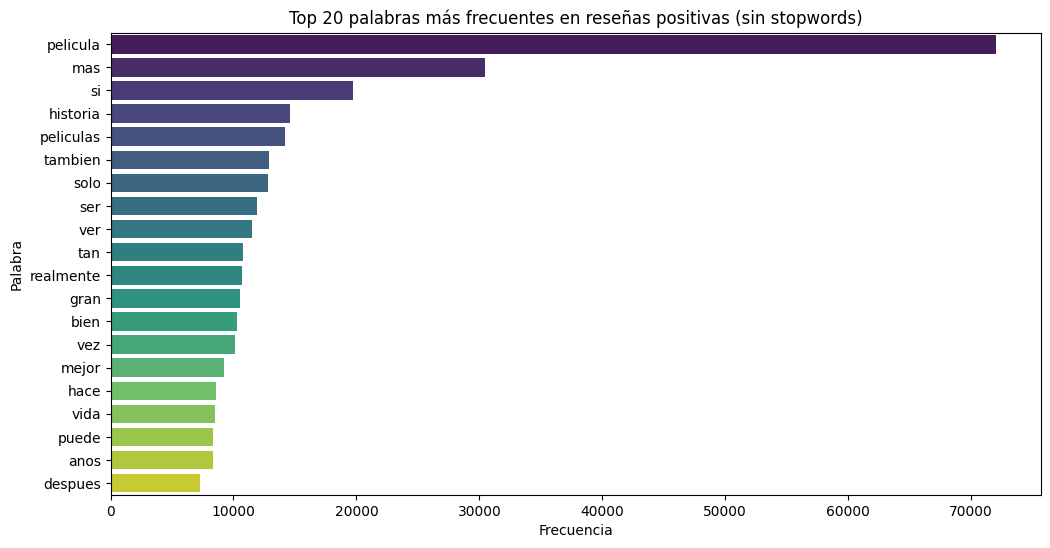

<ipython-input-15-d2b7f9b2fff8>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo_negative, palette='magma')


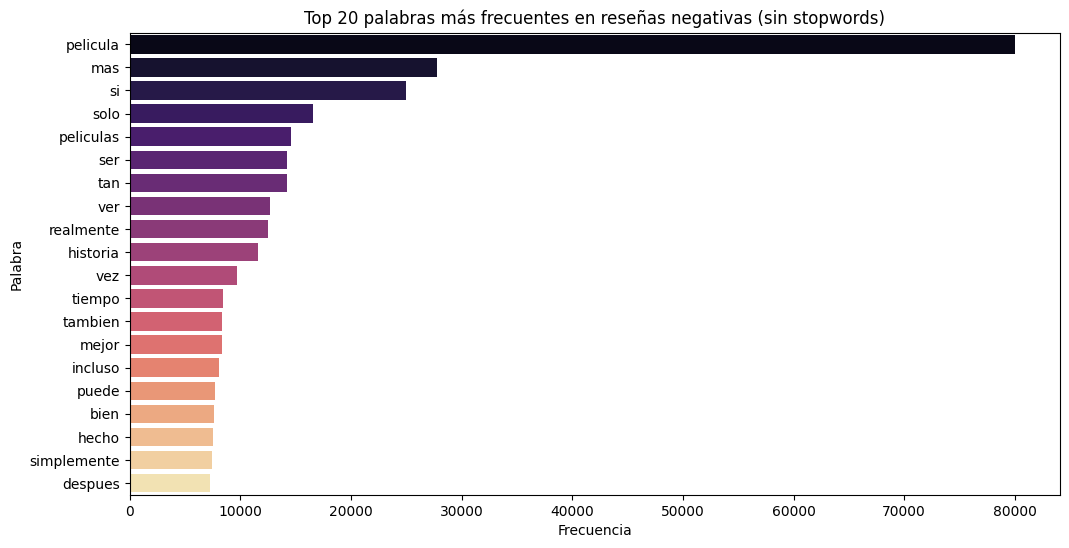

In [ ]:
# Análisis de sentimiento
# Filtrar palabras vacías (stopwords) antes de contar palabras
df['Tokens_Simples_Filtered'] = df['Tokens_Simples'].apply(lambda tokens: [word for word in tokens if word not in all_stopwords])

# Separar reseñas por sentimiento
positive_reviews = df[df['sentimiento'] == 'positivo']
negative_reviews = df[df['sentimiento'] == 'negativo']

# Obtener todas las palabras filtradas para cada sentimiento
positive_words = [word for tokens in positive_reviews['Tokens_Simples_Filtered'] for word in tokens]
negative_words = [word for tokens in negative_reviews['Tokens_Simples_Filtered'] for word in tokens]

# Contar frecuencias de palabras para cada sentimiento
conteo_positive_words = Counter(positive_words)
conteo_negative_words = Counter(negative_words)

# Mostrar las palabras más comunes para cada sentimiento
print("\nTop 20 palabras más frecuentes en reseñas positivas (sin stopwords):")
df_conteo_positive = pd.DataFrame(conteo_positive_words.most_common(20), columns=['Palabra', 'Frecuencia'])
display(df_conteo_positive)

print("\nTop 20 palabras más frecuentes en reseñas negativas (sin stopwords):")
df_conteo_negative = pd.DataFrame(conteo_negative_words.most_common(20), columns=['Palabra', 'Frecuencia'])
display(df_conteo_negative)

# --- Visualización de los resultados ---

# Gráfico para palabras más frecuentes en reseñas positivas
plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo_positive, palette='viridis')
plt.title('Top 20 palabras más frecuentes en reseñas positivas (sin stopwords)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

# Gráfico para palabras más frecuentes en reseñas negativas
plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo_negative, palette='magma')
plt.title('Top 20 palabras más frecuentes en reseñas negativas (sin stopwords)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

# Evidencia 3
Advertencia:

El proceso puede tardar mas de 30 min
## Paso 1

In [ ]:
!pip install -U spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 32.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import spacy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Count Vectorizer

Accuracy: 0.8489

Classification Report:

              precision    recall  f1-score   support

    negativo       0.83      0.88      0.85      5000
    positivo       0.87      0.82      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



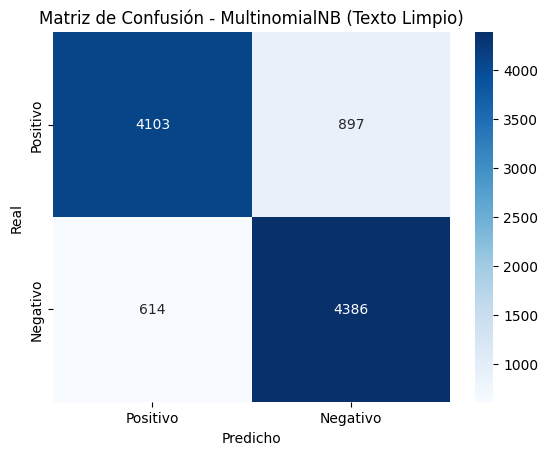

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Español_Limpio'])
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

modelo_nb = MultinomialNB()
modelo_nb.fit(X_train, y_train)

y_pred = modelo_nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=["positivo", "negativo"])
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["Positivo", "Negativo"], yticklabels=["Positivo", "Negativo"], cmap="Blues")
plt.title("Matriz de Confusión - MultinomialNB (Texto Limpio)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


In [ ]:
# Número total de tokens únicos
tokens_unicos = set()
for texto in df['Español_Limpio']:
    tokens_unicos.update(texto.split())
print("Número total de tokens únicos (Texto Limpio):", len(tokens_unicos))

# Promedio de tokens por documento
promedio_tokens_por_doc = df['Español_Limpio'].apply(lambda x: len(x.split())).mean()
print("Promedio de tokens por documento (Texto Limpio):", promedio_tokens_por_doc)

# Tamaño del vocabulario de CountVectorizer
vocabulario = vectorizer.get_feature_names_out()
print("Tamaño del vocabulario (CountVectorizer - Texto Limpio):", len(vocabulario))


Número total de tokens únicos (Texto Limpio): 170141
Promedio de tokens por documento (Texto Limpio): 238.84678
Tamaño del vocabulario (CountVectorizer - Texto Limpio): 155324


## Paso 2
### Stemmer

              precision    recall  f1-score   support

    negativo       0.80      0.87      0.83      4961
    positivo       0.86      0.78      0.82      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



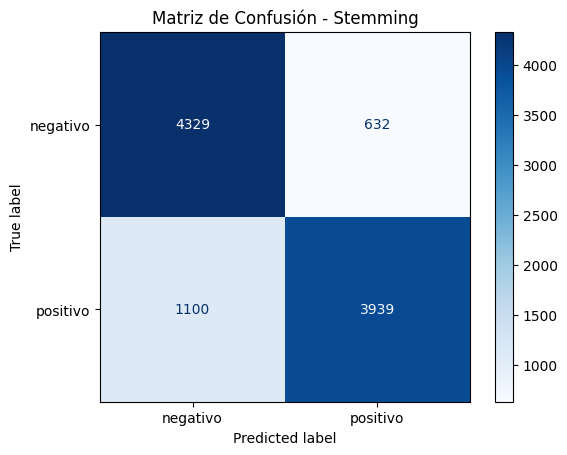

In [ ]:
stemmer = SnowballStemmer('spanish')

def aplicar_stemming(texto):
    tokens = nltk.word_tokenize(texto)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['Español_Stemming'] = df['Español_Limpio'].apply(aplicar_stemming)

# Vectorizamos
vectorizer_stem = CountVectorizer()
X_stem = vectorizer_stem.fit_transform(df['Español_Stemming'])

y = df['sentimiento']

# Entrenamos
X_train, X_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.2, random_state=42)

model_stem = MultinomialNB()
model_stem.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = model_stem.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz de Confusion
cm = confusion_matrix(y_test, y_pred, labels=['negativo', 'positivo'])

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negativo', 'positivo'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Stemming')
plt.show()

In [ ]:
#Numero Total de Tokens
tokens_stem = ' '.join(df['Español_Stemming']).split()
total_tokens_unicos_stem = len(set(tokens_stem))
print("Tokens únicos (Stemming):", total_tokens_unicos_stem)

#Promedio de Tokens
promedio_tokens_por_doc_stem = df['Español_Stemming'].apply(lambda x: len(x.split())).mean()
print("Promedio de tokens por documento (Stemming):", promedio_tokens_por_doc_stem)

#Tamaño del Vocabulario de CountVectroizer
vocabulario_stem = vectorizer_stem.get_feature_names_out()
print("Tamaño del vocabulario (Stemming):", len(vocabulario_stem))


Tokens únicos (Stemming): 107360
Promedio de tokens por documento (Stemming): 238.85288
Tamaño del vocabulario (Stemming): 107334


### Lematizacion

              precision    recall  f1-score   support

    negativo       0.80      0.88      0.84      4961
    positivo       0.87      0.79      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



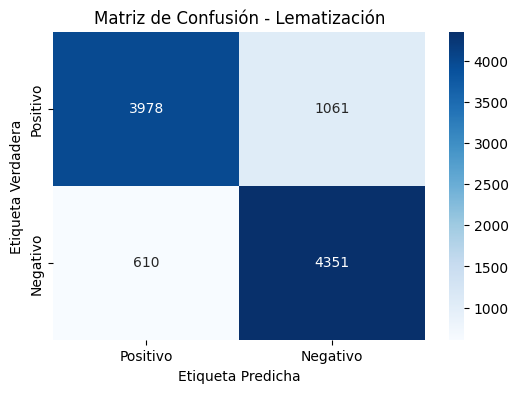

In [ ]:
nlp = spacy.load('es_core_news_sm')

def lematizar(texto):
    doc = nlp(texto)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

df['Lemas'] = df['Español_Limpio'].apply(lematizar)

df['Texto_Lematizado'] = df['Lemas'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Texto_Lematizado'])

y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred))

# Matriz
cm = confusion_matrix(y_test, y_pred, labels=["positivo", "negativo"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Positivo", "Negativo"], yticklabels=["Positivo", "Negativo"])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - Lematización')
plt.show()

In [ ]:
# Tokens únicos + tamaño del vocabulario
num_tokens_unicos_lemma = len(vectorizer.get_feature_names_out())

# Promedio de tokens por documento
tokens_por_doc_lemma = X.sum(axis=1)
promedio_tokens_lemma = tokens_por_doc_lemma.mean()

print(f"Tokens únicos (Lematización): {num_tokens_unicos_lemma}")
print(f"Promedio de tokens por documento (Lematización): {promedio_tokens_lemma:.5f}")
print(f"Tamaño del vocabulario (Lematización): {num_tokens_unicos_lemma}")


Tokens únicos (Lematización): 169935
Promedio de tokens por documento (Lematización): 129.67488
Tamaño del vocabulario (Lematización): 169935


### StopWords

              precision    recall  f1-score   support

    negativo       0.83      0.88      0.85      4961
    positivo       0.87      0.82      0.84      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



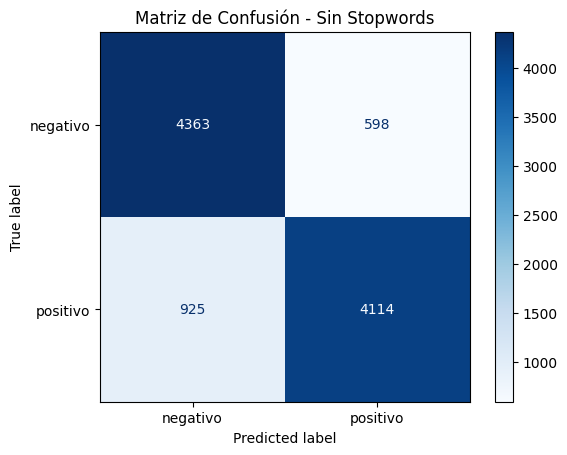

In [ ]:
stopwords_es = set(stopwords.words('spanish'))

df['Tokens_Stopwords'] = df['Español_Limpio'].apply(lambda texto: [
    palabra for palabra in texto.split() if palabra not in stopwords_es
])

df['Texto_Stopwords'] = df['Tokens_Stopwords'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Texto_Stopwords'])
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entrenamienot
modelo = MultinomialNB()
modelo.fit(X_train, y_train)

#Prediccion
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Sin Stopwords")
plt.show()


In [ ]:
tokens_total_stopwords = df['Tokens_Stopwords'].apply(len).sum()
promedio_tokens_stopwords = df['Tokens_Stopwords'].apply(len).mean()
tam_vocabulario_stopwords = len(vectorizer.get_feature_names_out())

print(f"Tokens únicos (Stopwords): {tam_vocabulario_stopwords}")
print(f"Promedio de tokens por documento (Stopwords): {promedio_tokens_stopwords:.5f}")
print(f"Tamaño del vocabulario (Stopwords): {tam_vocabulario_stopwords}")

Tokens únicos (Stopwords): 169935
Promedio de tokens por documento (Stopwords): 130.54340
Tamaño del vocabulario (Stopwords): 169935


## Convinaciones
### Stemming + StopWords

              precision    recall  f1-score   support

    negativo       0.81      0.87      0.84      4961
    positivo       0.87      0.80      0.83      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



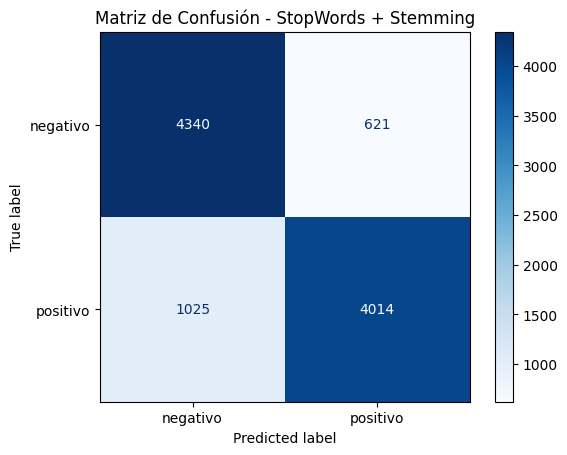

In [ ]:
stemmer = SnowballStemmer("spanish")
stopwords_es = set(stopwords.words('spanish'))

def stopwords_stemming(texto):
    tokens = nltk.word_tokenize(texto)
    tokens_filtrados = [word for word in tokens if word not in stopwords_es]
    tokens_stem = [stemmer.stem(word) for word in tokens_filtrados]
    return tokens_stem

df['Tokens_Stopwords_Stemming'] = df['Español_Limpio'].apply(stopwords_stemming)
df['Texto_Stopwords_Stemming'] = df['Tokens_Stopwords_Stemming'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Texto_Stopwords_Stemming'])
y = df['sentimiento']

# Entrenar y evaluar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = MultinomialNB()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

# Matriz
cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - StopWords + Stemming")
plt.show()

In [ ]:
tokens_total = df['Tokens_Stopwords_Stemming'].apply(len).sum()
promedio_tokens = df['Tokens_Stopwords_Stemming'].apply(len).mean()
tam_vocabulario = len(vectorizer.get_feature_names_out())

print(f"Tokens únicos (Stopwords + Stemming): {tam_vocabulario}")
print(f"Promedio de tokens por documento (Stopwords + Stemming): {promedio_tokens:.5f}")
print(f"Tamaño del vocabulario (Stopwords + Stemming): {tam_vocabulario}")

Tokens únicos (Stopwords + Stemming): 107283
Promedio de tokens por documento (Stopwords + Stemming): 130.54910
Tamaño del vocabulario (Stopwords + Stemming): 107283


### Lemmatización + StopWords

              precision    recall  f1-score   support

    negativo       0.81      0.87      0.84      4961
    positivo       0.86      0.80      0.83      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



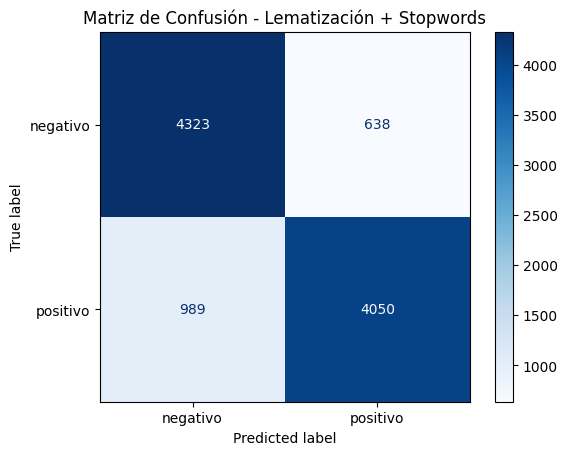

In [ ]:
stopwords_es = set(stopwords.words('spanish'))
nlp = spacy.load('es_core_news_sm')

def lematizar_sin_stopwords(texto):
    doc = nlp(texto)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

df['Lemas_Stopwords'] = df['Español_Limpio'].apply(lematizar_sin_stopwords)
df['Texto_Lemas_Stopwords'] = df['Lemas_Stopwords'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Texto_Lemas_Stopwords'])
y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = MultinomialNB()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Lematización + Stopwords")
plt.show()

In [ ]:
tokens_total = df['Texto_Lemas_Stopwords'].apply(lambda x: len(x.split())).sum()
tokens_por_doc = df['Texto_Lemas_Stopwords'].apply(lambda x: len(x.split())).mean()
vocabulario = len(vectorizer.get_feature_names_out())

print(f"Tokens únicos (Lemmatización + StopWords): {tokens_total}")
print(f"Promedio de tokens por documento (Lemmatización + StopWords): {tokens_por_doc:.5f}")
print(f"Tamaño del vocabulario (Lemmatización + StopWords): {vocabulario}")

Tokens únicos (Lemmatización + StopWords): 5459235
Promedio de tokens por documento (Lemmatización + StopWords): 109.18470
Tamaño del vocabulario (Lemmatización + StopWords): 155324
